In [69]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import emoji
import preprocessor as p
import re

from nltk.stem.snowball import SnowballStemmer 

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn import svm

from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from imblearn.over_sampling import SMOTE

import scipy.sparse

from wordcloud import WordCloud

# Read the data

In [2]:
def read_data(path): # file read
    
    read= os.listdir(path)
    
    for r in read:
        if r.endswith(".csv"):
            file=r
            
    df = pd.read_csv(file)
    
    return df
    

In [3]:
path=r"C:\\Users\\PANNI\\Szakdoga"
text_sentiment=read_data(path)
text_sentiment

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
...,...,...,...,...
39995,1753918954,neutral,showMe_Heaven,@JohnLloydTaylor
39996,1753919001,love,drapeaux,Happy Mothers Day All my love
39997,1753919005,love,JenniRox,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,ipdaman1,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


# Examination of the data

In [4]:
label=text_sentiment["sentiment"]
labelencoder = LabelEncoder() # string labels convert to numbers
num_label=labelencoder.fit_transform(label)
num_label

array([ 2, 10, 10, ...,  7,  5,  7])

In [5]:
label_classes=list(labelencoder.classes_)
label_classes

['anger',
 'boredom',
 'empty',
 'enthusiasm',
 'fun',
 'happiness',
 'hate',
 'love',
 'neutral',
 'relief',
 'sadness',
 'surprise',
 'worry']

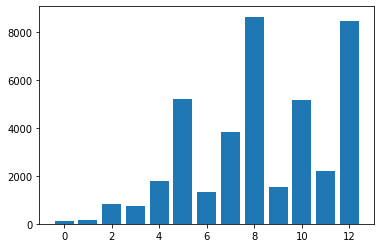

In [6]:
counter = Counter(num_label)  # information about classes

plt.bar(counter.keys(), counter.values())
plt.show()

# Pre-processing

In [7]:
def tweet_clean(text):
    data=[]
    
    for i in text:
        data.append(p.clean(i)) # hastag, url,emoji ect remove
        
    return data

In [8]:
tweet=tweet_clean(text_sentiment["content"])

In [9]:
def stemming(text): # stemming
    snow_stemmer = SnowballStemmer(language='english')
    
    string=" " 
    stem_text=[]
    for sentence in text:
        # sentence split
        words = sentence.split()                
        stem=[]
        for w in words:
            # words stemming
            stemming=snow_stemmer.stem(w)       
            stem.append(stemming)
            
        stem_text.append(string.join(stem))
        
    # cleaning function uses this output
    df=pd.DataFrame(stem_text,columns=["text"])
    output=df["text"]
    return output

In [10]:
stem_text=stemming(tweet)

In [11]:
def cleaning(texts):

    texts = texts.str.lower()
    
    # remove duplicate
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
    texts = texts.str.replace(pattern, r"\1")

    # remove contraction
    texts = texts.str.replace(r"(can't|cannot)", 'can not')
    texts = texts.str.replace(r"n't", ' not')
    texts = texts.str.replace(r"i'm","i am")
    texts = texts.str.replace(r"im","i am")
    texts = texts.str.replace(r"you're","you are")

    # stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.remove('not')
    stopwords.remove('nor')
    stopwords.remove('no')
    texts = texts.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))
        
    return texts

In [12]:
texts=cleaning(stem_text)

In [13]:
def punctuation(text): # remove punctuation
    data_p=[]
    string = " "
    
    for i in text:
        tokenizer = nltk.corpus.RegexpTokenizer(r'\w+')
        no_p=tokenizer.tokenize(i)
        data_p.append(string.join(no_p))
        
    return data_p


In [14]:
texts=punctuation(texts)

# Word Cloud

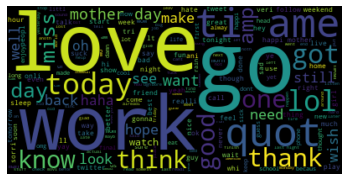

In [15]:
# frequent words all the texts
string=" "
text_wcloud = string.join(texts)

wordcloud = WordCloud().generate(text_wcloud)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Frequent words

In [16]:
def freq_words(word,text):
    f=[]
    for i in text:
        i.lower()
        if word in i:
            f.append(1)
        else:
            f.append(0) 
    return f

# egy listát ad vissza, aminek az 1 ha az i-dik mondat tartalmazza a szót különben 0

In [17]:
def freq_list(word_list,text):
    whole=[]
    for word in word_list:
        l=freq_words(word,text)
        whole.append(l)
    return whole

# egy listát ad vissza, amelynek az i-dik eleme egy listát tartalmaz az adott szóról

In [18]:
f_words=["miss","like","love","day","work","sad","happy","mother","thank","fun","lol","hate","not",
         "bored","good","no","quot","haha","sucks","go","think","amp","ti","ame","one"]

In [19]:
total_list=freq_list(f_words,texts)

In [20]:
new_df=pd.DataFrame(text_sentiment['tweet_id'],columns=['tweet_id']) # for the new features

In [21]:
new_df["miss"]=total_list[0]
new_df["like"]=total_list[1]
new_df["love"]=total_list[2]
new_df["day"]=total_list[3]
new_df["work"]=total_list[4]
new_df["sad"]=total_list[5]
new_df["happy"]=total_list[6]
new_df["mother"]=total_list[7]
new_df["thank"]=total_list[8]
new_df["fun"]=total_list[9]
new_df["lol"]=total_list[10]
new_df["hate"]=total_list[11]
new_df["not"]=total_list[12]
new_df["bored"]=total_list[13]
new_df["good"]=total_list[14]
new_df["no"]=total_list[15]
new_df["quot"]=total_list[16]
new_df["haha"]=total_list[17]
new_df["sucks"]=total_list[18]
new_df["go"]= total_list[19]
new_df["think"] = total_list[20]
new_df["amp"] = total_list[21]
new_df["ti"] = total_list[22]
new_df["ame"] = total_list[23]
new_df["one"] = total_list[24]

In [22]:
new_df

,tweet_id,miss,like,love,day,work,sad,happy,mother,thank,...,no,quot,haha,sucks,go,think,amp,ti,ame,one
0,1956967341,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1956967666,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1956967696,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1956967789,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1956968416,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1753918954,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39996,1753919001,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
39997,1753919005,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
39998,1753919043,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Count words

In [23]:
def words_num(text):
    words_num=[]
    for i in text:
        sentence=nltk.word_tokenize(i) # mondatokat felbontja szavakra
        count=len(sentence)            # megszámolja mennyi szó van benne
        words_num.append(count)
    return words_num

In [24]:
words_number=words_num(texts)
new_df["words_number"]=words_number

# Tags

In [25]:
def tag_in_sentence(tg,text):
    tag_lst=[]
    for i in text:
        tokens = nltk.word_tokenize(i)             # mondatokat teljesen szétbontása (lista)
        txt=nltk.Text(tokens)                      # text-é alakítja a listát
        tags = nltk.pos_tag(txt)                   # tag-el
        count = Counter(tag for word,tag in tags)  # tuple: (tag,count)
        
        item=count[tg]                             # a beadott tagnak a száma a mondatban
        tag_lst.append(item)
    
    return tag_lst

# olyan listát kapunk vissza, aminek az elemei az i-edik mondatban a keresett tag-jeink száma 

In [26]:
def tag_list(tag_lst,text):
    t_list=[]
    for i in tag_lst:
        tis=tag_in_sentence(i,text)
        t_list.append(tis)
    return t_list

# olyan listát kapunk vissza,aminek az i-edik eleme egy listát tartalmaz az adott tag számáról.

In [27]:
tag_l=["CC","FW","JJ","JJR","NN","NNP","NNS","UH","VB","VBD","VBG","VBN"]

In [28]:
total_tag=tag_list(tag_l,texts)

In [29]:
new_df["CC"]=total_tag[0]
new_df["FW"]=total_tag[1]
new_df["JJ"]=total_tag[2]
new_df["JJR"]=total_tag[3]
new_df["NN"]=total_tag[4]
new_df["NNP"]=total_tag[5]
new_df["NNS"]=total_tag[6]
new_df["UH"]=total_tag[7]
new_df["VB"]=total_tag[8]
new_df["VBD"]=total_tag[9]
new_df["VBG"]=total_tag[10]
new_df["VBN"]=total_tag[11]

In [30]:
new_df

,tweet_id,miss,like,love,day,work,sad,happy,mother,thank,...,JJ,JJR,NN,NNP,NNS,UH,VB,VBD,VBG,VBN
0,1956967341,0,0,0,0,0,0,0,0,0,...,1,0,4,0,0,0,2,0,0,0
1,1956967666,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,0,0,0,0
2,1956967696,0,0,0,1,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
3,1956967789,0,0,0,0,0,0,0,0,0,...,1,0,2,0,0,0,0,0,0,0
4,1956968416,0,0,0,0,0,0,0,0,0,...,2,0,3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1753918954,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39996,1753919001,0,0,1,1,0,0,0,1,0,...,0,0,2,0,0,0,1,0,0,0
39997,1753919005,0,0,0,1,0,0,0,1,0,...,1,0,6,0,0,0,1,0,0,0
39998,1753919043,0,0,0,0,0,0,0,0,0,...,3,0,7,0,0,0,1,0,0,0


# CountVectorizer

In [31]:
count_v = CountVectorizer() 
count_v.fit(texts) 

sentence_train=count_v.transform(texts)

In [32]:
matrix_train=scipy.sparse.csr_matrix(new_df.values) # my features sparse matrix

In [33]:
feature=scipy.sparse.hstack((matrix_train, sentence_train))

print(feature.shape)
feature

(40000, 25775)


<40000x25775 sparse matrix of type '<class 'numpy.int64'>'
	with 544835 stored elements in COOrdinate format>

# Train set - Validation set - Test set 

In [34]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(feature, num_label, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [35]:
print(x_train.shape, x_val.shape,x_test.shape, y_train.shape,y_val.shape,y_test.shape)

(30000, 25775) (6000, 25775) (4000, 25775) (30000,) (6000,) (4000,)


# SMOTE

In [ ]:
oversample = SMOTE()
X_smote_train, y_smote_train = oversample.fit_resample(x_train, y_train)

In [ ]:
counter_smote = Counter(y_smote_train)

plt.bar(counter_smote.keys(), counter_smote.values())
plt.show()

# Decision tree

In [36]:
d_tree = DecisionTreeClassifier(max_depth=6)
d_tree = d_tree.fit(x_train,y_train)
d_tree

DecisionTreeClassifier(max_depth=6)

In [37]:
y_pred_tree=d_tree.predict(x_val)

In [38]:
print(classification_report(y_val, y_pred_tree))

C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00       115
           3       0.00      0.00      0.00       103
           4       0.00      0.00      0.00       248
           5       0.33      0.12      0.17       789
           6       0.55      0.17      0.26       203
           7       0.52      0.39      0.45       558
           8       0.29      0.60      0.39      1321
           9       0.00      0.00      0.00       243
          10       0.45      0.17      0.25       798
          11       0.00      0.00      0.00       326
          12       0.31      0.54      0.39      1256

    accuracy                           0.33      6000
   macro avg       0.19      0.15      0.15      6000
weighted avg       0.30      0.33      0.28      6000



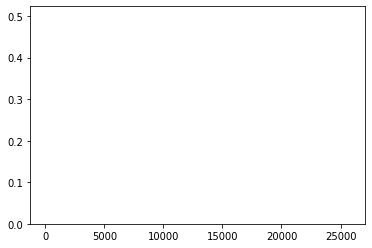

In [39]:
importance_tree = d_tree.feature_importances_

plt.bar([x for x in range(len(importance_tree))], importance_tree)
plt.show()

# Ensemble

In [40]:
r_forest = RandomForestClassifier(n_estimators=20,max_depth=10, random_state=3)
r_forest.fit(x_train,y_train)
r_forest

RandomForestClassifier(max_depth=10, n_estimators=20, random_state=3)

In [41]:
y_pred_forest = r_forest.predict(x_val)

In [42]:
print(classification_report(y_val, y_pred_forest))

C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00       115
           3       0.00      0.00      0.00       103
           4       0.00      0.00      0.00       248
           5       0.20      0.00      0.01       789
           6       0.00      0.00      0.00       203
           7       0.71      0.02      0.04       558
           8       0.26      0.62      0.37      1321
           9       0.00      0.00      0.00       243
          10       0.25      0.00      0.00       798
          11       0.00      0.00      0.00       326
          12       0.29      0.66      0.40      1256

    accuracy                           0.28      6000
   macro avg       0.13      0.10      0.06      6000
weighted avg       0.24      0.28      0.17      6000



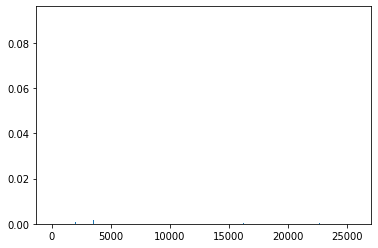

In [43]:
importance_forest = r_forest.feature_importances_

plt.bar([x for x in range(len(importance_forest))], importance_forest)
plt.show()

# Logistic Regression

In [44]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression()

In [45]:
y_pred_logreg = logreg.predict(x_val)

In [46]:
print(classification_report(y_val, y_pred_logreg))

C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00       115
           3       0.00      0.00      0.00       103
           4       0.00      0.00      0.00       248
           5       0.00      0.00      0.00       789
           6       0.00      0.00      0.00       203
           7       0.00      0.00      0.00       558
           8       0.00      0.00      0.00      1321
           9       0.00      0.00      0.00       243
          10       0.00      0.00      0.00       798
          11       0.00      0.00      0.00       326
          12       0.21      1.00      0.35      1256

    accuracy                           0.21      6000
   macro avg       0.02      0.08      0.03      6000
weighted avg       0.04      0.21      0.07      6000



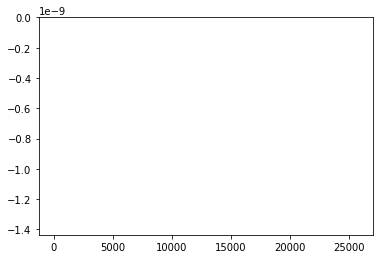

In [47]:
importance_logreg = logreg.coef_[0]

# plot feature importance
plt.bar([x for x in range(len(importance_logreg))], importance_logreg)
plt.show()

# Naive Bayes

In [48]:
naiv_b = MultinomialNB()
naiv_b.fit(x_train, y_train)

MultinomialNB()

In [49]:
y_pred_naiv_b = naiv_b.predict(x_val)

In [50]:
print(classification_report(y_val,y_pred_naiv_b))

C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00       115
           3       0.00      0.00      0.00       103
           4       0.00      0.00      0.00       248
           5       0.30      0.22      0.25       789
           6       0.00      0.00      0.00       203
           7       0.52      0.23      0.32       558
           8       0.30      0.63      0.41      1321
           9       0.00      0.00      0.00       243
          10       0.31      0.08      0.13       798
          11       0.00      0.00      0.00       326
          12       0.30      0.51      0.37      1256

    accuracy                           0.31      6000
   macro avg       0.13      0.13      0.11      6000
weighted avg       0.26      0.31      0.25      6000



# SVM

In [51]:
svm=svm.LinearSVC()
svm.fit(x_train, y_train)

C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC()

In [52]:
y_pred_svm = svm.predict(x_val)

In [53]:
print(classification_report(y_val,y_pred_svm))

C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00       115
           3       0.00      0.00      0.00       103
           4       0.00      0.00      0.00       248
           5       0.00      0.00      0.00       789
           6       0.00      0.00      0.00       203
           7       0.00      0.00      0.00       558
           8       0.00      0.00      0.00      1321
           9       0.00      0.00      0.00       243
          10       0.00      0.00      0.00       798
          11       0.05      1.00      0.10       326
          12       0.00      0.00      0.00      1256

    accuracy                           0.05      6000
   macro avg       0.00      0.08      0.01      6000
weighted avg       0.00      0.05      0.01      6000



# TfidfVectorizer

In [54]:
tfidf_transformer = TfidfTransformer()
tfidf_train=tfidf_transformer.fit_transform(sentence_train)

feature1=scipy.sparse.hstack((matrix_train, tfidf_train))

In [55]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(feature1, num_label, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

# Decision tree

In [56]:
d_tree1 = DecisionTreeClassifier(max_depth=6)
d_tree1 = d_tree1.fit(x_train,y_train)
d_tree1

DecisionTreeClassifier(max_depth=6)

In [57]:
y_pred_tree1=d_tree1.predict(x_val)

In [58]:
print(classification_report(y_val, y_pred_tree1))

C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00       134
           3       0.00      0.00      0.00       114
           4       0.00      0.00      0.00       261
           5       0.33      0.11      0.17       715
           6       0.42      0.14      0.20       222
           7       0.55      0.37      0.45       598
           8       0.30      0.63      0.41      1343
           9       0.00      0.00      0.00       225
          10       0.49      0.17      0.26       754
          11       0.00      0.00      0.00       312
          12       0.34      0.57      0.42      1284

    accuracy                           0.34      6000
   macro avg       0.19      0.15      0.15      6000
weighted avg       0.31      0.34      0.29      6000



# Ensemble

In [59]:
r_forest1 = RandomForestClassifier(n_estimators=20,max_depth=10, random_state=3)
r_forest1.fit(x_train,y_train)
r_forest1

RandomForestClassifier(max_depth=10, n_estimators=20, random_state=3)

In [60]:
y_pred_forest1 = r_forest1.predict(x_val)

In [61]:
print(classification_report(y_val, y_pred_forest1))

C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00       134
           3       0.00      0.00      0.00       114
           4       0.00      0.00      0.00       261
           5       0.25      0.00      0.01       715
           6       0.00      0.00      0.00       222
           7       0.56      0.05      0.08       598
           8       0.27      0.72      0.39      1343
           9       0.00      0.00      0.00       225
          10       0.00      0.00      0.00       754
          11       0.00      0.00      0.00       312
          12       0.31      0.57      0.40      1284

    accuracy                           0.29      6000
   macro avg       0.11      0.10      0.07      6000
weighted avg       0.21      0.29      0.18      6000



# Logistic Regression

In [62]:
logreg1 = LogisticRegression(class_weight="balanced")
logreg1.fit(x_train, y_train)

LogisticRegression(class_weight='balanced')

In [63]:
y_pred_logreg1 = logreg1.predict(x_val)

In [64]:
print(classification_report(y_val, y_pred_logreg1))

C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00       134
           3       0.00      0.00      0.00       114
           4       0.00      0.00      0.00       261
           5       0.00      0.00      0.00       715
           6       0.00      0.00      0.00       222
           7       0.00      0.00      0.00       598
           8       0.00      0.00      0.00      1343
           9       0.00      0.00      0.00       225
          10       0.13      1.00      0.22       754
          11       0.00      0.00      0.00       312
          12       0.00      0.00      0.00      1284

    accuracy                           0.13      6000
   macro avg       0.01      0.08      0.02      6000
weighted avg       0.02      0.13      0.03      6000



# Naive Bayes

In [65]:
naiv_b1 = MultinomialNB()
naiv_b1.fit(x_train, y_train)

MultinomialNB()

In [66]:
y_pred_naiv_b1 = naiv_b1.predict(x_val)

In [67]:
print(classification_report(y_val,y_pred_naiv_b1))

C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00       134
           3       0.00      0.00      0.00       114
           4       0.00      0.00      0.00       261
           5       0.27      0.09      0.13       715
           6       0.00      0.00      0.00       222
           7       0.57      0.03      0.05       598
           8       0.29      0.63      0.40      1343
           9       0.00      0.00      0.00       225
          10       1.00      0.00      0.01       754
          11       0.00      0.00      0.00       312
          12       0.26      0.58      0.36      1284

    accuracy                           0.28      6000
   macro avg       0.18      0.10      0.07      6000
weighted avg       0.34      0.28      0.19      6000



# SVM

In [70]:
SVM1=svm.LinearSVC()
SVM1.fit(x_train, y_train)

C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC()

In [71]:
y_pred_svm1 = SVM1.predict(x_val)

In [72]:
print(classification_report(y_val,y_pred_svm1))

C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PANNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00       134
           3       0.00      0.00      0.00       114
           4       0.00      0.00      0.00       261
           5       0.00      0.00      0.00       715
           6       0.00      0.00      0.00       222
           7       0.00      0.00      0.00       598
           8       0.22      1.00      0.37      1343
           9       0.00      0.00      0.00       225
          10       0.00      0.00      0.00       754
          11       0.00      0.00      0.00       312
          12       0.00      0.00      0.00      1284

    accuracy                           0.22      6000
   macro avg       0.02      0.08      0.03      6000
weighted avg       0.05      0.22      0.08      6000

